# Comparing fluxes with other products




In [1]:
import numpy as np
import xarray as xr
import rioxarray as rxr
import geopandas as gpd
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap

from odc.geo.geobox import zoom_out
from odc.geo.xr import assign_crs
from odc.algo import xr_reproject

import sys
sys.path.append('/g/data/os22/chad_tmp/NEE_modelling/')
from collect_prediction_data import allNaN_arg

sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools/')
from dea_tools.spatial import xr_rasterize

import warnings
warnings.filterwarnings("ignore")

In [2]:
from datacube.utils.dask import start_local_dask
client = start_local_dask(mem_safety_margin='2Gb')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 1
Total threads: 14,Total memory: 510.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42107,Workers: 1
Dashboard: /proxy/8787/status,Total threads: 14
Started: Just now,Total memory: 510.00 GiB
Comm: tcp://127.0.0.1:33747,Total threads: 14
Dashboard: /proxy/34643/status,Memory: 510.00 GiB
Nanny: tcp://127.0.0.1:38443,


## Analysis Parameters

In [3]:
var = 'GPP' #ER #NEE #GPP
var_fc = 'GPP' #TER #NEE #GPP
var_cable = 'gpp' #nbp #er #gpp
suffix='20230320'
trim=True
trim_date = '2003','2022'

results_name = var+'_2003_2022_1km_quantiles_'+suffix+'.nc'
# upper = 'NEE_2003_2021_5km_LGBM_quantiles.nc'

## Open various datasets

In [4]:
ds = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/'+results_name)
ds.attrs['nodata'] = np.nan

In [5]:
# mask = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/results/prediction_data/data_5km.nc')
# mask = mask[['FPAR']].to_array().isnull().all('variable')
# mask = mask.isel(time=1)

# ds = ds.where(~mask)
# ds_upper = ds_upper.where(~mask)

### Fluxcom

In [6]:
ds_fc = assign_crs(xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/FLUXCOM/'+var_fc+'_rs.nc'), crs='epsg:4326').sel(time=slice('2003', '2015'))

ds_fc.attrs['nodata'] = np.nan
ds_fc['latitude'] = ds_fc.latitude.astype('float32')
ds_fc['longitude'] = ds_fc.longitude.astype('float32')

ds_fc_met = assign_crs(xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/FLUXCOM/'+var_fc+'_rs_meteo_era5.nc').sel(time=slice('2003', '2018')), crs='epsg:4326')
ds_fc_met = ds_fc_met.rename({'lat':'latitude', 'lon':'longitude'})
ds_fc_met.attrs['nodata'] = np.nan
ds_fc_met['latitude'] = ds_fc_met.latitude.astype('float32')
ds_fc_met['longitude'] = ds_fc_met.longitude.astype('float32')


In [7]:
ds_fc['time'] = ds.sel(time=slice('2003', '2015')).time
ds_fc_met['time'] = ds.sel(time=slice('2003', '2018')).time

### CABLE

<!-- '/g/data/os22/chad_tmp/NEE_modelling/data/CABLE/CABLE_ER_10km_monthly_2000_2019.nc' -->

In [8]:
cable = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/CABLE/CABLE-BIOS/CABLE_BIOS_'+var_cable+'_25km_monthly_2003_2019.nc')
cable_pop = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/CABLE/CABLE-POP_v10/CABLE-POP_'+var_cable+'_100km_monthly_2003_2020.nc')
cable_pop = cable_pop[var_cable]
# cable_nee = cable_nee.sel(time=slice('2003', '2015'))

### GOSAT Inversion

Metz etal 2023

In [9]:
gosat = pd.read_csv('/g/data/os22/chad_tmp/NEE_modelling/data/metz_2023/aus_transcom_gosat_inversion_PgCyear.csv',
                   parse_dates=True).set_index('time')
gosat = gosat.to_xarray()
gosat=gosat['GOSAT_INVERSION']
gosat['time'] = ds.sel(time=slice('2009-04', '2018-12')).time

### Fire emissions GFASv12

In [10]:
fire = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/FireEmissions_10km_monthly_2003_2022.nc')
fire = fire.sum(['x', 'y'])
fire = fire*12

### Obs GPP

In [11]:
if var == 'GPP':
    modis_gpp = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/1km/MODIS_GPP_1km_monthly_2002_2021.nc')
    modis_gpp.attrs['nodata'] = np.nan

    gosif_gpp = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/5km/GOSIF_GPP_5km_monthly_2002_2021.nc')
    gosif_gpp.attrs['nodata'] = np.nan
    
    diffuse = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/1km/DIFFUSE_GPP_1km_monthly_2003_2021.nc')
    diffuse.attrs['nodata'] = np.nan

### Villalobos et al 

Needed to fix the dataset before it could be opened. Used the R script in data/villalobos/

In [12]:
fn = '/g/data/os22/chad_tmp/NEE_modelling/data/villalobos/post.tif'
post = rxr.open_rasterio(fn).rename({'band':'month'})
post['month']=ds.sel(time=slice('2015', '2019')).time.values
post = post.rename({'month':'time'})
#post = xr_reproject(post, geobox=post.odc.geobox.to_crs('epsg:3577').compat, resampling='nearest')
# post = assign_crs(post, crs='epsg:3577')
post.attrs['nodata'] = np.nan
post.attrs['units'] = 'PgC/year'

fn = '/g/data/os22/chad_tmp/NEE_modelling/data/villalobos/land.tif'
cbl = rxr.open_rasterio(fn).rename({'band':'month'})
cbl['month']=ds.sel(time=slice('2015', '2019')).time.values
cbl = cbl.rename({'month':'time'})
#cable = xr_reproject(cable, geobox=cable.odc.geobox.to_crs('epsg:3577').compat, resampling='nearest')
# post = assign_crs(post, crs='epsg:3577')
cbl.attrs['nodata'] = np.nan
cbl.attrs['units'] = 'PgC/year'

fn = '/g/data/os22/chad_tmp/NEE_modelling/data/villalobos/fossil.tif'
ff = rxr.open_rasterio(fn).rename({'band':'month'})
ff['month']=ds.sel(time=slice('2015', '2019')).time.values
ff = ff.rename({'month':'time'})
#ff = xr_reproject(ff, geobox=ff.odc.geobox.to_crs('epsg:3577').compat, resampling='nearest')
# post = assign_crs(post, crs='epsg:3577')
ff.attrs['nodata'] = np.nan
ff.attrs['units'] = 'PgC/year'

#subtract fossile fuels from inversion
post = post - ff

# create a mask for this janky dataset
mask_inv = cbl.where(cbl==0).isel(time=1)
mask_inv = mask_inv.astype(bool)

post = post.where(mask_inv)

## Reproject to Albers Equal Area

In [ ]:
# grid = zoom_out(ds.odc.geobox, 20)
# grid = grid.to_crs('EPSG:3577')
# grid

In [16]:
ds = xr_reproject(ds.chunk(dict(x=1100,y=1100)),
                  geobox=ds.odc.geobox.to_crs('EPSG:3577').compat,
                  resampling='bilinear').compute()

ds_upper = ds.sel(quantile=[0.25,0.75])
ds = ds.sel(quantile=0.5).drop('quantile')

In [18]:
ds_fc = xr_reproject(ds_fc, geobox=ds_fc.odc.geobox.to_crs('EPSG:3577').compat, resampling='bilinear')
ds_fc = ds_fc[var_fc] #.where(~mask.astype(bool))
ds_fc = ds_fc*30 #/day to /month

ds_fc_met = xr_reproject(ds_fc_met, geobox=ds_fc_met.odc.geobox.to_crs('EPSG:3577').compat, resampling='bilinear')
ds_fc_met = ds_fc_met[var_fc] #.where(~mask.astype(bool))
ds_fc_met = ds_fc_met*30 #/day to /month

In [19]:
cable = assign_crs(cable, crs='epsg:4326')
cable = xr_reproject(cable, geobox=cable.odc.geobox.to_crs('EPSG:3577').compat, resampling='bilinear') #['nbp']

cable_pop = assign_crs(cable_pop, crs='epsg:4326')
cable_pop = xr_reproject(cable_pop, geobox=cable_pop.odc.geobox.to_crs('EPSG:3577').compat, resampling='bilinear') #['nbp']

In [22]:
diffuse

<xarray.DataArray 'DIFFUSE_GPP' (time: 228, latitude: 3400, longitude: 4200)>
[3255840000 values with dtype=float32]
Coordinates:
  * time         (time) datetime64[ns] 2003-01-15 2003-02-15 ... 2021-12-15
  * latitude     (latitude) float32 -10.01 -10.02 -10.02 ... -43.99 -43.99
  * longitude    (longitude) float32 112.0 112.0 112.0 ... 154.0 154.0 154.0
    spatial_ref  int32 ...
Attributes:
    nodata:   nan

In [31]:
if var == 'GPP':
    # grid = zoom_out(ds.odc.geobox, 5)
    # grid = grid.to_crs('EPSG:3577')
    modis_gpp = xr_reproject(modis_gpp.chunk(dict(latitude=1100,longitude=1100)),
                             geobox=ds.odc.geobox.compat,
                             resampling='average').compute()
    gosif_gpp = xr_reproject(gosif_gpp, geobox=gosif_gpp.odc.geobox.to_crs('EPSG:3577').compat, resampling='bilinear')

SyntaxError: unexpected EOF while parsing (2468351818.py, line 5)

In [34]:
if var == 'GPP':
    diffuse = xr_reproject(diffuse.chunk(dict(latitude=1100,longitude=1100)),
                           geobox=diffuse.odc.geobox.to_crs('EPSG:3577').compat,
                           resampling='bilinear').compute()
    diffuse = diffuse*30 #/day to /month

## Convert to total C in (petagrams) rather than gC/m2


In [35]:
ds = ds * ds.geobox.resolution[1]**2 * 1e-15 *12
ds_upper = ds_upper * ds_upper.geobox.resolution[1]**2 * 1e-15 *12

ds_fc = ds_fc * ds_fc.geobox.resolution[1]**2 * 1e-15 * 12
ds_fc_met = ds_fc_met * ds_fc_met.geobox.resolution[1]**2 * 1e-15 * 12

cable = cable * cable.geobox.resolution[1]**2 * 1e-15 *12
cable_pop = cable_pop * cable_pop.geobox.resolution[1]**2 * 1e-15 *12

if var == 'GPP':
    modis_gpp = modis_gpp * modis_gpp.geobox.resolution[1]**2 * 1e-12
    modis_gpp = modis_gpp*12
    gosif_gpp = gosif_gpp * gosif_gpp.geobox.resolution[1]**2 * 1e-15
    gosif_gpp = gosif_gpp*12
    diffuse = diffuse * diffuse.geobox.resolution[1]**2 * 1e-15
    diffuse = diffuse*12

## Plot time-series

In [36]:
if trim:
    ds = ds.sel(time=slice(trim_date[0], trim_date[1]))
    ds_upper = ds_upper.sel(time=slice(trim_date[0], trim_date[1]))
    ds_fc = ds_fc.sel(time=slice(trim_date[0], trim_date[1]))
    ds_fc_met = ds_fc_met.sel(time=slice(trim_date[0], trim_date[1]))
    cable = cable.sel(time=slice(trim_date[0], trim_date[1]))
    cable_pop = cable_pop.sel(time=slice(trim_date[0], trim_date[1]))
    
    if var=='GPP':
        modis_gpp = modis_gpp.sel(time=slice(trim_date[0], trim_date[1]))
        gosif_gpp = gosif_gpp.sel(time=slice(trim_date[0], trim_date[1]))
        diffuse = diffuse.sel(time=slice(trim_date[0], trim_date[1]))

In [37]:
ds_1d = ds.sum(['x', 'y'])
ds_1d_upper = ds_upper.sum(['x', 'y'])

ds_fc_1d = ds_fc.sum(['x', 'y'])
ds_fc_met_1d = ds_fc_met.sum(['x', 'y'])

post_1d = post.sum(['x', 'y'])
cable_1d = cable.sum(['x', 'y'])
cable_pop_1d = cable_pop.sum(['x', 'y'])

if var=='GPP':
    gosif_gpp_1d = gosif_gpp.sum(['x', 'y'])
    modis_gpp_1d = modis_gpp.sum(['x', 'y'])
    diffuse_1d = diffuse.sum(['x', 'y'])

### add fire to NEE estimates

In [38]:
if var=='NEE':
    ds_fire_1d = ds_1d+fire
    ds_fire_clim_mean = ds_fire_1d.groupby('time.month').mean()
    ds_fire_anom = (ds_fire_1d.groupby('time.month') - ds_fire_clim_mean)

### Plot time-series w/o rolling mean

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15,7))
ax.plot(ds_1d.time.values, ds_1d,  label='This study')

ax.fill_between(ds_1d.time, ds_1d_upper.sel(quantile=0.25).rolling(time=3, min_periods=1).mean(),
                ds_1d_upper.sel(quantile=0.75).rolling(time=3, min_periods=1).mean(), alpha=0.2)

ax.plot(ds_fc_1d.time.values, ds_fc_1d, linestyle='--', label='Fluxcom-RS', alpha=0.8)
ax.plot(ds_fc_met_1d.time.values, ds_fc_met_1d, linestyle='--', label='Fluxcom-Met', alpha=0.8)
ax.plot(cable_1d.time.values, cable_1d, linestyle='--', label='CABLE-BIOS', alpha=0.8)
ax.plot(cable_pop_1d.time.values, cable_pop_1d, linestyle='--', label='CABLE-POP', alpha=0.8)

if var=='NEE':
    ax.plot(post_1d.time.values, post_1d, linestyle='--', label='Inversion', alpha=0.8)
    ax.plot(ds_1d.time.values, ds_fire_1d,c='blue', linestyle='--', label='This study+Fire')
    plt.axhline(0, c='grey')

if var == 'GPP':
    ax.plot(modis_gpp_1d.time.values, modis_gpp_1d, linestyle='--', label='MODIS', alpha=0.75)
    ax.plot(gosif_gpp_1d.time.values, gosif_gpp_1d, linestyle='--', label='GOSIF', alpha=0.75)
    ax.plot(diffuse_1d.time.values, diffuse_1d, linestyle='--', label='DIFFUSE', alpha=0.75)

fontsize=16
ax.set_ylabel(var+'PgC/year')

if var=='NEE':
    ax.text(.015, .30, f'Fluxcom-RS: {ds_fc_1d.mean().values:.2f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .25, f'Fluxcom-Met: {ds_fc_met_1d.mean().values:.2f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .20, f'This study: {ds_1d.mean().values:.2f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .15, f'Cable-BIOS: {cable_1d.mean().values:.2f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .10, f'Cable-POP: {cable_pop_1d.mean().values:.2f} PgC/yr',
            transform=ax.transAxes,fontsize=fontsize)
    ax.text(.015, .05, f'Inversion: {post_1d.mean().values:.2f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.legend(loc='lower right', fontsize=fontsize);

if var == 'GPP':
    ax.text(.015, .95, f'Fluxcom-RS: {ds_fc_1d.mean().values:.2f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .90, f'Fluxcom-Met: {ds_fc_met_1d.mean().values:.2f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .85, f'This study: {ds_1d.mean().values:.2f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .80, f'GOSIF: {gosif_gpp_1d.mean().values:.2f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .75, f'MODIS: {modis_gpp_1d.mean().values:.2f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .70, f'Cable-BIOS: {cable_1d.mean().values:.2f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .65, f'Cable-POP: {cable_pop_1d.mean().values:.2f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .60, f'DIFFUSE: {diffuse_1d.mean().values:.2f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.legend(loc='upper right', fontsize=fontsize)

if var == 'ER':
    ax.text(.015, .95, f'Fluxcom-RS: {ds_fc_1d.mean().values:.2f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .90, f'Fluxcom-Met: {ds_fc_met_1d.mean().values:.2f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .85, f'This study: {ds_1d.mean().values:.2f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .80, f'Cable-BIOS: {cable_1d.mean().values:.2f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .75, f'Cable-POP: {cable_pop_1d.mean().values:.2f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.legend(loc='upper right', fontsize=fontsize)

### Plot timeseries with rolling mean

In [39]:
roll_len=12

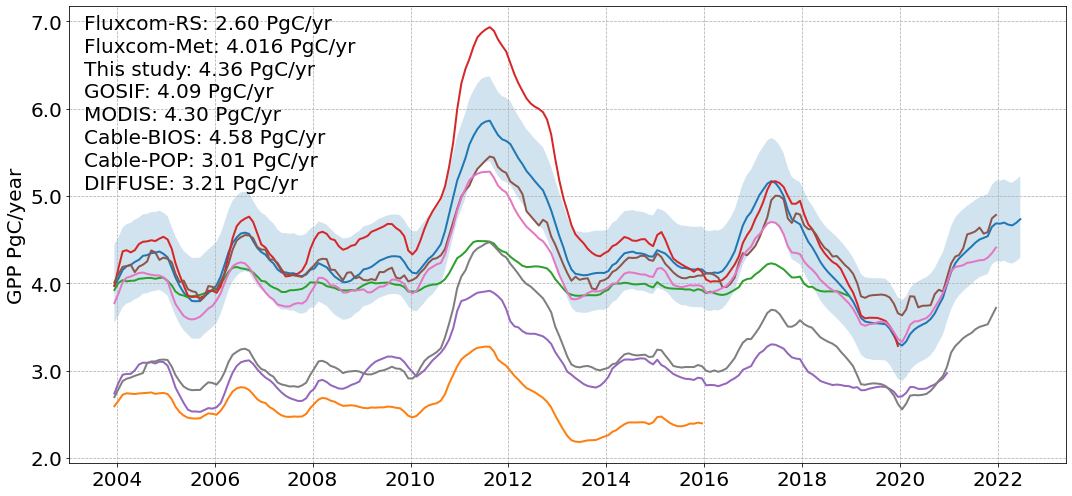

In [40]:
fontsize=20
line=2

fig, ax = plt.subplots(1,1, figsize=(15,7))
ax.plot(ds_1d.time.values, ds_1d.rolling(time=roll_len, min_periods=roll_len).mean(),  label='This study', linewidth=line)
ax.fill_between(ds_1d.time, ds_1d_upper.sel(quantile=0.25).rolling(time=roll_len, min_periods=roll_len).mean(),
                ds_1d_upper.sel(quantile=0.75).rolling(time=roll_len, min_periods=roll_len).mean(), alpha=0.2)

ax.plot(ds_fc_1d.time.values, ds_fc_1d.rolling(time=roll_len, min_periods=roll_len).mean(), label='Fluxcom-RS', linewidth=line)
ax.plot(ds_fc_met_1d.time.values, ds_fc_met_1d.rolling(time=roll_len, min_periods=roll_len).mean(),  label='Fluxcom-Met', linewidth=line)
ax.plot(cable_1d.time.values, cable_1d.rolling(time=roll_len, min_periods=roll_len).mean(), label='CABLE-BIOS', linewidth=line)
ax.plot(cable_pop_1d.time.values, cable_pop_1d.rolling(time=roll_len, min_periods=roll_len).mean(),  label='CABLE-POP', linewidth=line)

if var=='NEE':
    ax.plot(post_1d.time.values, post_1d.rolling(time=roll_len, min_periods=roll_len).mean(), label='Inversion', color='darkkhaki', linewidth=line)
    ax.plot(gosat.time.values, gosat.rolling(time=roll_len, min_periods=roll_len).mean(), label='GOSAT-Inversion', color='gold', linewidth=line)
    ax.plot(ds_1d.time.values, ds_fire_1d.rolling(time=roll_len, min_periods=roll_len).mean(),  color='black', label='This study+Fire', linewidth=line)
    plt.axhline(0, c='grey')

if var == 'GPP':
    ax.plot(modis_gpp_1d.time.values, modis_gpp_1d.rolling(time=roll_len, min_periods=roll_len).mean(), label='MODIS', linewidth=line)
    ax.plot(gosif_gpp_1d.time.values, gosif_gpp_1d.rolling(time=roll_len, min_periods=roll_len).mean(), label='GOSIF', linewidth=line)
    ax.plot(diffuse_1d.time.values, diffuse_1d.rolling(time=roll_len, min_periods=roll_len).mean(), label='DIFFUSE', linewidth=line)

if var=='NEE':
    ax.text(.015, .375, f'Fluxcom-RS: {ds_fc_1d.mean().values:.2f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .325, f'Fluxcom-Met: {ds_fc_met_1d.mean().values:.2f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .275, f'This study: {ds_1d.mean().values:.2f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .225, f'This study+Fire: {ds_fire_1d.mean().values:.2f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .175, f'Cable-BIOS: {cable_1d.mean().values:.2f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .125, f'Cable-POP: {cable_pop_1d.mean().values:.2f} PgC/yr',
            transform=ax.transAxes,fontsize=fontsize)
    ax.text(.015, .075, f'Inversion: {post_1d.mean().values:.2f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .025, f'GOSAT-Inversion: {gosat.mean().values:.2f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)

if var == 'GPP':
    ax.text(.015, .95, f'Fluxcom-RS: {ds_fc_1d.mean().values:.2f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .90, f'Fluxcom-Met: {ds_fc_met_1d.mean().values:.2f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .85, f'This study: {ds_1d.mean().values:.2f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .80, f'GOSIF: {gosif_gpp_1d.mean().values:.2f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .75, f'MODIS: {modis_gpp_1d.mean().values:.2f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .70, f'Cable-BIOS: {cable_1d.mean().values:.2f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .65, f'Cable-POP: {cable_pop_1d.mean().values:.2f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .60, f'DIFFUSE: {diffuse_1d.mean().values:.2f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)

if var == 'ER':
    ax.text(.015, .95, f'Fluxcom-RS: {ds_fc_1d.mean().values:.2f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .90, f'Fluxcom-Met: {ds_fc_met_1d.mean().values:.2f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .85, f'This study: {ds_1d.mean().values:.2f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .80, f'Cable-BIOS: {cable_1d.mean().values:.2f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .75, f'Cable-POP: {cable_pop_1d.mean().values:.2f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)

ax.grid('off', which='major', axis='both', linestyle='--', linewidth=0.75)
ax.grid('off', which='major', axis='y', linestyle='--', linewidth=0.75)
ax.set_ylabel(var+' PgC/year', fontsize=fontsize);
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
ax.set_yticklabels(['{:3.1f}'.format(x) for x in ax.get_yticks()])
plt.tight_layout()
fig.savefig('/g/data/os22/chad_tmp/NEE_modelling/results/figs/annual_mean_timeseries_'+var+'.png', bbox_inches='tight')

### Save legend of plot above

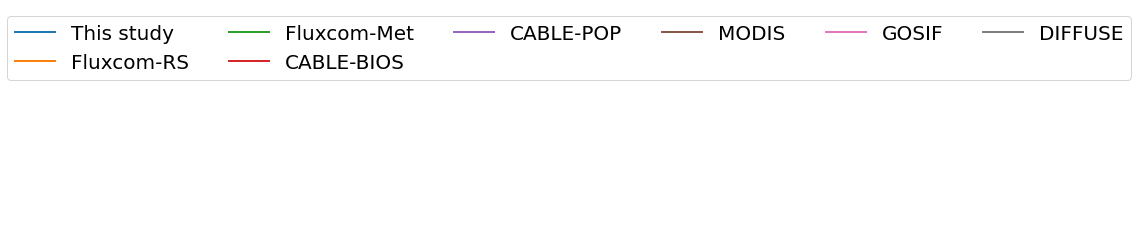

In [41]:
# get handles and labels for reuse
label_params = ax.get_legend_handles_labels() 

figl, axl = plt.subplots()
axl.axis(False)
axl.legend(*label_params, loc="best", fontsize=20, markerscale=4.0, ncol=6)
figl.savefig('/g/data/os22/chad_tmp/NEE_modelling/results/figs/legend_annual_mean_timeseries_'+var+'.png', bbox_inches='tight')

## Convert to anomalies

### Climatology

In [42]:
import warnings
warnings.filterwarnings("ignore")

ds_clim_mean = ds.groupby('time.month').mean()
ds_upper_clim_mean = ds_upper.groupby('time.month').mean()

ds_fc_clim_mean = ds_fc.groupby('time.month').mean()
ds_fc_met_clim_mean = ds_fc_met.groupby('time.month').mean()
post_clim_mean = post.groupby('time.month').mean()
cable_clim_mean = cable.groupby('time.month').mean()
cable_pop_clim_mean = cable_pop.groupby('time.month').mean()
gosat_clim_mean = gosat.groupby('time.month').mean()

if var=='GPP':
    modis_gpp_clim_mean = modis_gpp.groupby('time.month').mean()
    gosif_gpp_clim_mean = gosif_gpp.groupby('time.month').mean()
    diffuse_clim_mean = diffuse.groupby('time.month').mean()


### Anomalies

In [43]:
ds_anom = (ds.groupby('time.month') - ds_clim_mean)
ds_upper_anom = (ds_upper.groupby('time.month') - ds_upper_clim_mean) 

ds_fc_anom = (ds_fc.groupby('time.month') - ds_fc_clim_mean)
ds_fc_met_anom = (ds_fc_met.groupby('time.month') - ds_fc_met_clim_mean)
post_anom = (post.groupby('time.month') - post_clim_mean)
cable_anom = (cable.groupby('time.month') - cable_clim_mean)
cable_pop_anom = (cable_pop.groupby('time.month') - cable_pop_clim_mean)
gosat_anom = (gosat.groupby('time.month') - gosat_clim_mean)

if var=='GPP':
    modis_gpp_anom = (modis_gpp.groupby('time.month') - modis_gpp_clim_mean)
    gosif_gpp_anom = (gosif_gpp.groupby('time.month') - gosif_gpp_clim_mean)
    diffuse_anom = (diffuse.groupby('time.month') - diffuse_clim_mean)

    # modis_gpp_anom_annual = modis_gpp.resample(time='1Y', label='left', loffset='6M').sum() - modis_gpp_clim_mean_annual
    # gosif_gpp_anom_annual = gosif_gpp.resample(time='1Y', label='left', loffset='6M').sum() - gosif_gpp_clim_mean_annual

## Interannual variability

In [44]:
annual_ds = ds.resample(time='1Y').sum()
annual_ds_upper = ds_upper.resample(time='1Y').sum()
annual_post = post.resample(time='1Y').sum()
annual_gosat = gosat.resample(time='1Y').sum()
annual_cable = cable.resample(time='1Y').sum()
annual_cable_pop = cable_pop.resample(time='1Y').sum()
annual_ds_fc = ds_fc.resample(time='1Y').sum()
annual_ds_fc_met = ds_fc_met.resample(time='1Y').sum()

if var=='GPP':
    annual_modis = modis_gpp.resample(time='1Y').sum()
    annual_gosif = gosif_gpp.resample(time='1Y').sum()
    annual_diffuse = diffuse.resample(time='1Y').sum()

if var=='NEE':
    annual_fire = fire.resample(time='1Y').sum()

In [45]:
print('fluxcom-rs: ', (annual_ds_fc.sum(['x','y']) / 12).std().values)
print('fluxcom-met: ',(annual_ds_fc_met.sum(['x','y']) / 12).std().values)
print('CABLE-BIOS: ',(annual_cable.sum(['x','y']) / 12).std().values)
print('CABLE-POP: ',(annual_cable_pop.sum(['x','y']) / 12).std().values)
print('Inversion: ',(annual_post.sum(['x','y']) / 12).std().values)
print('This Study: ',(annual_ds.sum(['x','y']) / 12).std().values)
print('GOSAT-Inversion: ',(annual_gosat/ 12).std().values)

if var=='GPP':
    print('MODIS: ',(annual_modis.sum(['x','y']) / 12).std().values)
    print('GOSIF: ',(annual_gosif.sum(['x','y']) / 12).std().values)
    print('DIFFUSE: ',(annual_diffuse.sum(['x','y']) / 12).std().values)

fluxcom-rs:  0.22786453
fluxcom-met:  0.13291849
CABLE-BIOS:  0.782599064625895
CABLE-POP:  0.2915360666451468
Inversion:  0.26150894
This Study:  0.6354602
GOSAT-Inversion:  0.20110339107782788
MODIS:  0.37619644
GOSIF:  0.38163593
DIFFUSE:  0.4175515


### Zonal summaries

In [46]:
ds_1D = ds_anom.sum(['x','y'])
ds_upper_1D = ds_upper_anom.sum(['x','y'])

ds_fc_1D = ds_fc_anom.sum(['x','y'])
ds_fc_met_1D = ds_fc_met_anom.sum(['x','y'])

post_1D = post_anom.sum(['x','y'])
cable_1D = cable_anom.sum(['x','y'])
cable_pop_1D = cable_pop_anom.sum(['x','y'])

if var=='GPP':
    modis_gpp_1D = modis_gpp_anom.sum(['x','y'])
    gosif_gpp_1D = gosif_gpp_anom.sum(['x','y'])
    diffuse_1D = diffuse_anom.sum(['x','y'])

### Plot timeseries

In [47]:
roll_len=12

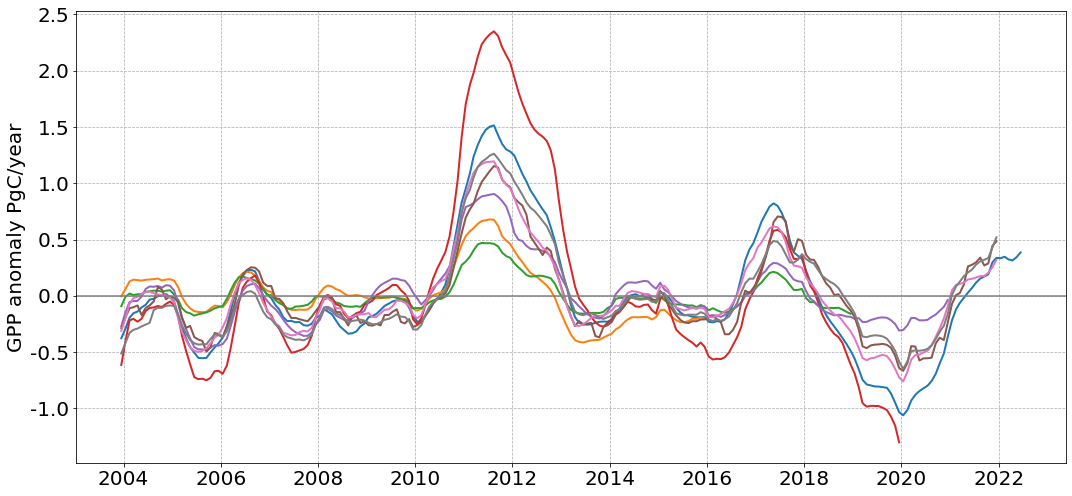

In [48]:
fontsize=20

fig, ax = plt.subplots(1,1, figsize=(15,7))
ax.plot(ds_1D.time.values, ds_1D.rolling(time=roll_len, min_periods=roll_len).mean(),  label='This study', linewidth=line)
ax.plot(ds_fc_1D.time.values, ds_fc_1D.rolling(time=roll_len, min_periods=roll_len).mean(),  label='Fluxcom-RS', linewidth=line)
ax.plot(ds_fc_met_1D.time.values, ds_fc_met_1D.rolling(time=roll_len, min_periods=roll_len).mean(),  label='Fluxcom-Met', linewidth=line)
ax.plot(cable_1D.time.values, cable_1D.rolling(time=roll_len, min_periods=roll_len).mean(), label='CABLE-BIOS', linewidth=line)
ax.plot(cable_pop_1D.time.values, cable_pop_1D.rolling(time=roll_len, min_periods=roll_len).mean(), label='CABLE-POP', linewidth=line)


if var=='NEE':
    ax.plot(post_1D.time.values, post_1D.rolling(time=roll_len, min_periods=roll_len).mean(), label='Inversion',color='darkkhaki', linewidth=line)
    ax.plot(gosat_anom.time.values, gosat_anom.rolling(time=roll_len, min_periods=roll_len).mean(), label='GOSAT-Inversion', color='gold', linewidth=line)
    ax.plot(ds_1D.time.values, ds_fire_anom.rolling(time=roll_len, min_periods=roll_len).mean(),  c='black', label='This study+Fire', linewidth=line)

if var == 'GPP':
    ax.plot(modis_gpp_1D.time.values, modis_gpp_1D.rolling(time=roll_len, min_periods=roll_len).mean(),  label='MODIS', linewidth=line)
    ax.plot(gosif_gpp_1D.time.values, gosif_gpp_1D.rolling(time=roll_len, min_periods=roll_len).mean(), label='GOSIF', linewidth=line)
    ax.plot(diffuse_1D.time.values, diffuse_1D.rolling(time=roll_len, min_periods=roll_len).mean(), label='DIFFUSE', linewidth=line)

ax.set_ylabel(var+' anomaly PgC/year', fontsize=fontsize)
plt.axhline(0, c='grey');

ax.grid('off', which='major', axis='both', linestyle='--', linewidth=0.75)
ax.grid('off', which='major', axis='y', linestyle='--', linewidth=0.75)
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
ax.set_yticklabels(['{:3.1f}'.format(x) for x in ax.get_yticks()])
plt.tight_layout()
fig.savefig('/g/data/os22/chad_tmp/NEE_modelling/results/figs/annual_anomaly_timeseries_'+var+'.png', bbox_inches='tight')

## Climatology timeseries

### Aus wide 

In [49]:
print('Seasonal range of '+var, ds_clim_mean.sum(['x','y']).max().values - ds_clim_mean.sum(['x','y']).min().values)

Seasonal range of GPP 1.4923449


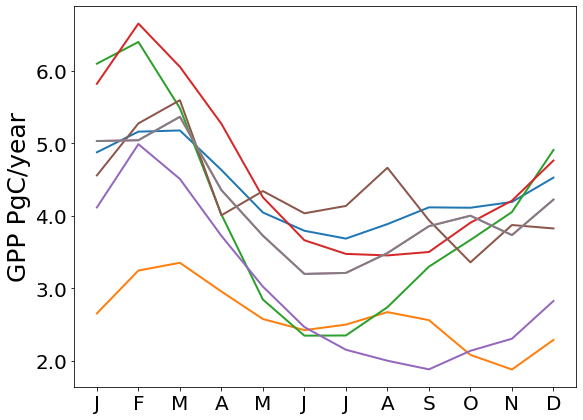

In [50]:
fig, ax = plt.subplots(1,1, figsize=(9,7))

y = ds_clim_mean.sum(['x','y']).values
x = ds_clim_mean.month.values

if var=='NEE':
    y_fire = ds_fire_clim_mean.values
    x_fire = ds_fire_clim_mean.month.values

y_fc = ds_fc_clim_mean.sum(['x','y']).values
x_fc = ds_fc_clim_mean.month.values

y_fc_met = ds_fc_met_clim_mean.sum(['x','y']).values
x_fc_met = ds_fc_met_clim_mean.month.values

y_post = post_clim_mean.sum(['x','y']).values
x_post = post_clim_mean.month.values

y_gosat = gosat_clim_mean.values
x_gosat = gosat_clim_mean.month.values

y_cable = cable_clim_mean.sum(['x','y']).values
x_cable = cable_clim_mean.month.values

y_cable_pop = cable_pop_clim_mean.sum(['x','y']).values
x_cable_pop = cable_pop_clim_mean.month.values

if var =='GPP':
    y_modis_gpp = modis_gpp_clim_mean.sum(['x','y']).values
    x_modis_gpp = modis_gpp_clim_mean.month.values

    y_gosif_gpp = gosif_gpp_clim_mean.sum(['x','y']).values
    x_gosif_gpp = gosif_gpp_clim_mean.month.values
    
    y_diffuse = gosif_gpp_clim_mean.sum(['x','y']).values
    x_diffuse = diffuse_clim_mean.month.values


ax.plot(x, y, label='This Study', linewidth=line)
if var=='NEE':
    ax.plot(x_fire, y_fire, label='This Study+Fire', c='black', linewidth=line)
ax.plot(x_fc, y_fc, label='Fluxcom-RS', linewidth=line)
ax.plot(x_fc_met, y_fc_met, label='Fluxcom-Met', linewidth=line)
ax.plot(x_cable, y_cable, label='Cable-BIOS', linewidth=line)
ax.plot(x_cable_pop, y_cable_pop, label='Cable-POP', linewidth=line)

if var=='NEE':
    ax.plot(x_post, y_post, label='Inversion', color='darkkhaki', linewidth=line)
    ax.plot(x_gosat, y_gosat, label='GOSAT-Inversion', color='gold', linewidth=line)

if var =='GPP':
    ax.plot(x_modis_gpp, y_modis_gpp, label='MODIS', linewidth=line)
    ax.plot(x_gosif_gpp, y_gosif_gpp, label='GOSIF', linewidth=line)
    ax.plot(x_diffuse, y_diffuse, label='DIFFUSE', linewidth=line)


if var=='NEE':
    ax.axhline(0, c='grey')
# ax.legend(loc='best', fontsize=15)

ax.set_yticklabels(['{:3.1f}'.format(x) for x in ax.get_yticks()])
ax.set_xticks(range(1,13))
ax.set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"], fontsize=15)    
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.set_ylabel(var+' PgC/year', fontsize=25);
plt.savefig('/g/data/os22/chad_tmp/NEE_modelling/results/figs/'+var+'_Aus_climatology_timeseries.png', bbox_inches='tight')

#### Save the legend as file

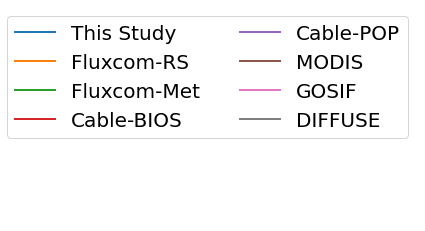

In [51]:
# get handles and labels for reuse
label_params = ax.get_legend_handles_labels() 

figl, axl = plt.subplots()
axl.axis(False)
axl.legend(*label_params, loc="best", fontsize=20, markerscale=2.0, ncol=2)
figl.savefig('/g/data/os22/chad_tmp/NEE_modelling/results/figs/climatology_legend_'+var+'.png', bbox_inches='tight')

### Per bioregion

In [52]:
bio = assign_crs(xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/bioclimatic_regions.nc'), crs='EPSG:4326')
gdf = gpd.read_file('/g/data/os22/chad_tmp/NEE_modelling/data/bioclimatic_regions.geojson')

In [53]:
def make_mask(xx, index):
    mask = xr_reproject(bio, geobox=xx.odc.geobox.compat, resampling='nearest')
    mask = mask.astype(int)
    mask['x'] = np.array([round(i,6) for i in mask.x.values])
    mask['y'] = np.array([round(i,6) for i in mask.y.values])
    mask = xr.where(mask==index, 1, 0)
    return mask

def round_coords(ds):
    ds['x'] = np.array([round(i,6) for i in ds.x.values])
    ds['y'] = np.array([round(i,6) for i in ds.y.values])
    return ds

In [54]:
# Dictionary to save results 
results = {}
for index, row in gdf.iterrows():
    index=index+1
    print(row['region_name'])
    datasets = {}
    
    ds_mask = make_mask(ds, index)
    ds_fc_mask = make_mask(ds_fc, index)
    ds_fc_met_mask = make_mask(ds_fc_met, index)
    cable_mask = make_mask(cable, index)
    cable_pop_mask = make_mask(cable_pop, index)
    post_mask = make_mask(post, index)
    
    dss = round_coords(ds_clim_mean).where(ds_mask)
    dss_fc = round_coords(ds_fc_clim_mean).where(ds_fc_mask)
    dss_fc_met = round_coords(ds_fc_met_clim_mean).where(ds_fc_met_mask)
    dss_cable= round_coords(cable_clim_mean).where(cable_mask)
    dss_cable_pop = round_coords(cable_pop_clim_mean).where(cable_pop_mask)
    dss_post = round_coords(post_clim_mean).where(post_mask)
    
    if var=='GPP':
        modis_gpp_mask = make_mask(modis_gpp, index)
        gosif_gpp_mask = make_mask(gosif_gpp, index)
        diffuse_mask = make_mask(diffuse, index)
        dss_modis = round_coords(modis_gpp_clim_mean).where(modis_gpp_mask)
        dss_gosif = round_coords(gosif_gpp_clim_mean).where(gosif_gpp_mask)
        dss_diffuse = round_coords(diffuse_clim_mean).where(diffuse_mask)
        
        datasets.update({
                    'This Study':dss,
                    'Fluxcom-RS':dss_fc,
                    'Fluxcom-Met':dss_fc_met,
                    'CABLE-BIOS':dss_cable,
                    'CABLE-POP':dss_cable_pop,
                    'MODIS-GPP':dss_modis,
                    'GOSIF-GPP':dss_gosif,
                    'DIFFUSE-GPP':dss_diffuse,
                    }
                   )
    if var=='NEE':
        datasets.update({
                        'This Study':dss,
                        'Fluxcom-RS':dss_fc,
                        'Fluxcom-Met':dss_fc_met,
                        'CABLE-BIOS':dss_cable,
                        'CABLE-POP':dss_cable_pop,
                        'Inversion':dss_post
                        }
                       )
    
    if var=='ER':
        datasets.update({
                        'This Study':dss,
                        'Fluxcom-RS':dss_fc,
                        'Fluxcom-Met':dss_fc_met,
                        'CABLE-BIOS':dss_cable,
                        'CABLE-POP':dss_cable_pop,
                        }
                       )
    
    # Append results to a dictionary using the attribute
    # column as an key
    results.update({row['region_name']: datasets})

Tropics
Savanna
Warm Temperate
Cool Temperate
Mediterranean
Desert


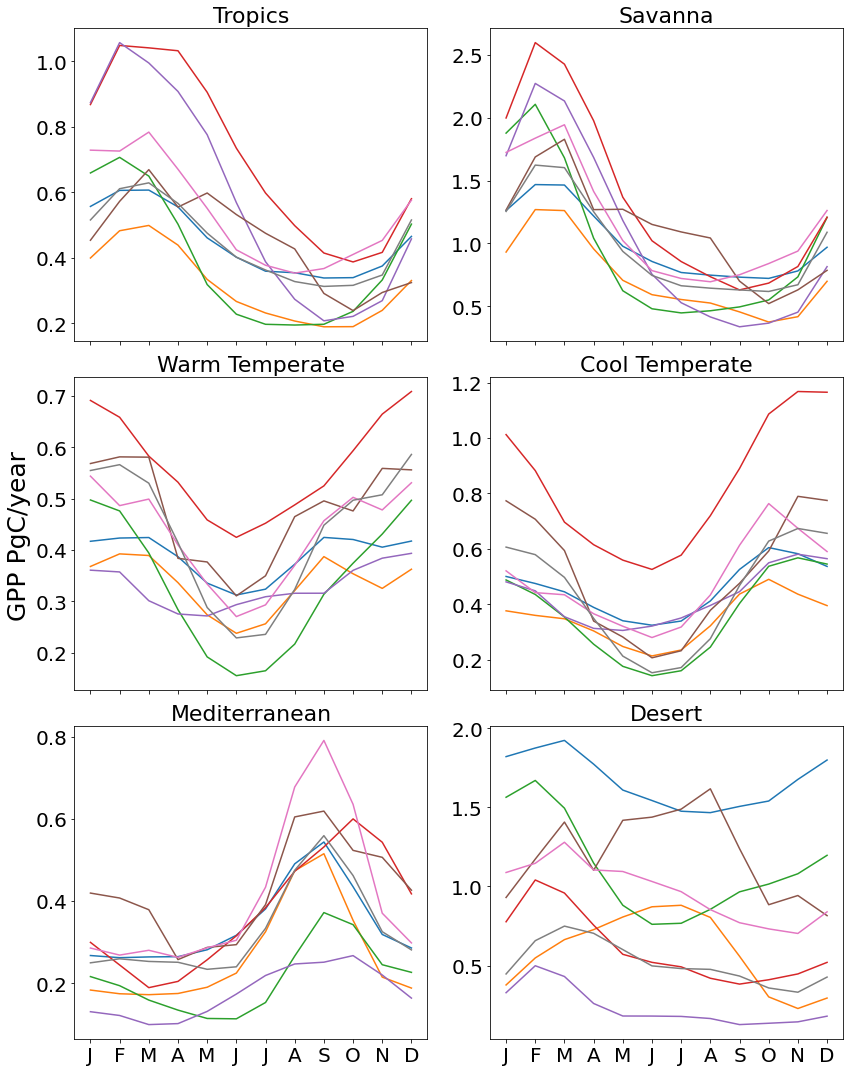

In [55]:
fig, axs = plt.subplots(3,2, figsize=(12,15), sharex=True)

for ax, k in zip(axs.ravel(), results.keys()):
    for source, da in results[k].items():
        _1D = da.sum(['x','y'])
        if source=='Inversion':
            _1D.plot(ax=ax, label=source, color='darkkhaki')
        else:    
            _1D.plot(ax=ax, label=source)
    if var=='NEE':
        ax.axhline(0, c='grey', linestyle='--')
    
    #ax.set_yticklabels(['{:3.1f}'.format(y) for y in ax.get_yticks()])
    ax.set_xticks(range(1,13))
    ax.set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"], fontsize=17)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.set_title(k, fontdict={'fontsize': 22})
    ax.set_ylabel('')
    ax.set_xlabel('')

#axs[0,0].legend(fontsize=15)
fig.supylabel(var+' PgC/year', fontsize=25)
plt.tight_layout()
plt.savefig('/g/data/os22/chad_tmp/NEE_modelling/results/figs/'+var+'_bioregion_climatology_timeseries.png', bbox_inches='tight');

## Climatology per-pixel

In [56]:
if var == 'NEE':
    max_mean_month = allNaN_arg(ds_clim_mean, 'month', 'min')
    max_mean_month_fc = allNaN_arg(ds_fc_clim_mean, 'month', 'min')
    max_mean_month_fc_met = allNaN_arg(ds_fc_met_clim_mean, 'month', 'min')
    max_mean_month_post = allNaN_arg(post_clim_mean, 'month', 'min')
    max_mean_month_cable = allNaN_arg(cable_clim_mean, 'month', 'min')
    max_mean_month_cable_pop = allNaN_arg(cable_pop_clim_mean, 'month', 'min')

else:
    if var=='GPP':
        max_mean_month = allNaN_arg(ds_clim_mean, 'month', 'max')
        max_mean_month_fc = allNaN_arg(ds_fc_clim_mean, 'month', 'max')
        max_mean_month_fc_met = allNaN_arg(ds_fc_met_clim_mean, 'month', 'max')
        max_mean_month_modis = allNaN_arg(modis_gpp_clim_mean, 'month', 'max')
        max_mean_month_gosif = allNaN_arg(gosif_gpp_clim_mean, 'month', 'max')
        max_mean_month_diffuse = allNaN_arg(diffuse_clim_mean, 'month', 'max')
        max_mean_month_cable = allNaN_arg(cable_clim_mean, 'month', 'max')
        max_mean_month_cable_pop = allNaN_arg(cable_pop_clim_mean, 'month', 'max')
    if var=='ER':
        max_mean_month = allNaN_arg(ds_clim_mean, 'month', 'max')
        max_mean_month_fc = allNaN_arg(ds_fc_clim_mean, 'month', 'max')
        max_mean_month_fc_met = allNaN_arg(ds_fc_met_clim_mean, 'month', 'max')
        max_mean_month_cable = allNaN_arg(cable_clim_mean, 'month', 'max')
        max_mean_month_cable_pop = allNaN_arg(cable_pop_clim_mean, 'month', 'max')

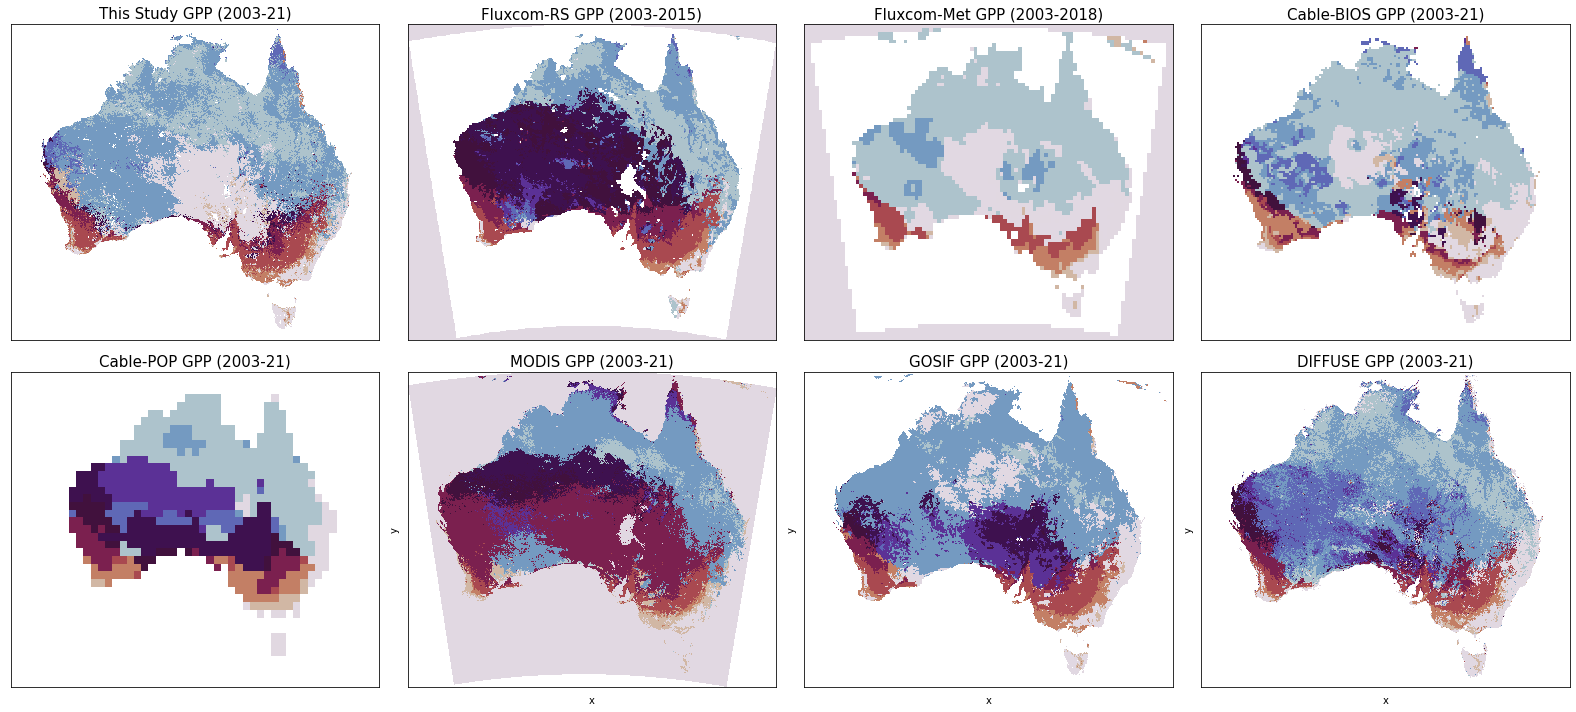

In [69]:
y_range = ' (2003-21)'
font=15
if var=='GPP':
    fig,ax = plt.subplots(2,4, figsize=(22,10))
    im = max_mean_month.plot.imshow(vmin=1, vmax=12, ax=ax[0,0], cmap='twilight', add_colorbar=False, add_labels=False)
    ax[0,0].set_title('This Study '+var+y_range, fontsize=font);

    im = max_mean_month_fc.plot.imshow(vmin=1, vmax=12, ax=ax[0,1], cmap='twilight', add_colorbar=False, add_labels=False)
    ax[0,1].set_title('Fluxcom-RS '+var+ ' (2003-2015)', fontsize=font);

    im = max_mean_month_fc_met.plot.imshow(vmin=1, vmax=12, ax=ax[0,2], cmap='twilight', add_colorbar=False, add_labels=False)
    ax[0,2].set_title('Fluxcom-Met '+var+' (2003-2018)', fontsize=font);

    im = max_mean_month_cable.plot.imshow(vmin=1, vmax=12, ax=ax[0,3], cmap='twilight', add_colorbar=False, add_labels=False)
    ax[0,3].set_title('Cable-BIOS '+var+y_range, fontsize=font);

    im = max_mean_month_cable_pop.plot.imshow(vmin=1, vmax=12, ax=ax[1,0], cmap='twilight', add_colorbar=False, add_labels=False)
    ax[1,0].set_title('Cable-POP '+var+y_range, fontsize=font);

    # im = max_mean_month_post.isel(x=range(12, 68), y=range(12, 68)).plot.imshow(vmin=1, vmax=12, ax=ax[1,2], cmap='twilight', add_colorbar=False, add_labels=False)
    # ax[1,2].set_title('Inversion '+var+' (2015-19)', fontsize=font);

    im = max_mean_month_modis.plot.imshow(vmin=1, vmax=12, ax=ax[1,1], cmap='twilight', add_colorbar=False)
    ax[1,1].set_title('MODIS '+var+y_range, fontsize=font);

    im = max_mean_month_gosif.plot.imshow(vmin=1, vmax=12, ax=ax[1,2], cmap='twilight', add_colorbar=False)
    ax[1,2].set_title('GOSIF '+var+y_range, fontsize=font);
    
    im = max_mean_month_diffuse.where(~np.isnan(diffuse_clim_mean.isel(month=1))).plot.imshow(vmin=1, vmax=12, ax=ax[1,3], cmap='twilight', add_colorbar=False)
    ax[1,3].set_title('DIFFUSE '+var+y_range, fontsize=font);

if var=='NEE':
    fig,ax = plt.subplots(2,3, figsize=(18,10))
    im = max_mean_month.plot.imshow(vmin=1, vmax=12, ax=ax[0,0], cmap='twilight', add_colorbar=False, add_labels=False)
    ax[0,0].set_title('This Study '+var+y_range, fontsize=font);

    im = max_mean_month_fc.plot.imshow(vmin=1, vmax=12, ax=ax[0,1], cmap='twilight', add_colorbar=False, add_labels=False)
    ax[0,1].set_title('Fluxcom-RS '+var+ ' (2003-2015)', fontsize=font);

    im = max_mean_month_fc_met.plot.imshow(vmin=1, vmax=12, ax=ax[0,2], cmap='twilight', add_colorbar=False, add_labels=False)
    ax[0,2].set_title('Fluxcom-Met '+var+' (2003-2018)', fontsize=font);

    im = max_mean_month_cable.plot.imshow(vmin=1, vmax=12, ax=ax[1,0], cmap='twilight', add_colorbar=False, add_labels=False)
    ax[1,0].set_title('Cable-BIOS '+var+y_range, fontsize=font);

    im = max_mean_month_cable_pop.plot.imshow(vmin=1, vmax=12, ax=ax[1,1], cmap='twilight', add_colorbar=False, add_labels=False)
    ax[1,1].set_title('Cable-POP '+var+y_range, fontsize=font);

    im = max_mean_month_post.isel(x=range(12, 68), y=range(12, 68)).plot.imshow(vmin=1, vmax=12, ax=ax[1,2], cmap='twilight', add_colorbar=False, add_labels=False)
    ax[1,2].set_title('Inversion '+var+' (2015-19)', fontsize=font);

if var=='ER':
    fig,ax = plt.subplots(2,3, figsize=(18,10))
    im = max_mean_month.plot.imshow(vmin=1, vmax=12, ax=ax[0,0], cmap='twilight', add_colorbar=False, add_labels=False)
    ax[0,0].set_title('This Study '+var+y_range, fontsize=font);

    im = max_mean_month_fc.plot.imshow(vmin=1, vmax=12, ax=ax[0,1], cmap='twilight', add_colorbar=False, add_labels=False)
    ax[0,1].set_title('Fluxcom-RS '+var+ ' (2003-2015)', fontsize=font);

    im = max_mean_month_fc_met.plot.imshow(vmin=1, vmax=12, ax=ax[0,2], cmap='twilight', add_colorbar=False, add_labels=False)
    ax[0,2].set_title('Fluxcom-Met '+var+' (2003-2018)', fontsize=font);

    im = max_mean_month_cable.plot.imshow(vmin=1, vmax=12, ax=ax[1,0], cmap='twilight', add_colorbar=False, add_labels=False)
    ax[1,0].set_title('Cable-BIOS '+var+y_range, fontsize=font);

    im = max_mean_month_cable_pop.plot.imshow(vmin=1, vmax=12, ax=ax[1,1], cmap='twilight', add_colorbar=False, add_labels=False)
    ax[1,1].set_title('Cable-POP '+var+y_range, fontsize=font);
    

ax[0,0].set_yticks([])
ax[0,1].set_yticks([])
ax[0,2].set_yticks([])
ax[1,0].set_yticks([])
ax[1,1].set_yticks([])
ax[1,2].set_yticks([])
ax[0,0].set_xticks([])
ax[0,1].set_xticks([])
ax[0,2].set_xticks([])
ax[1,0].set_xticks([])
ax[1,1].set_xticks([])
ax[1,2].set_xticks([])

if var=='GPP':
    ax[0,3].set_yticks([])
    ax[1,3].set_yticks([])
    ax[0,3].set_xticks([])
    ax[1,3].set_xticks([])

plt.tight_layout()
plt.savefig('/g/data/os22/chad_tmp/NEE_modelling/results/figs/month_of_max_'+var+'.png', bbox_inches='tight')


### Save the colorbar

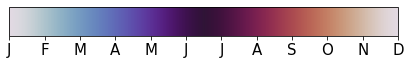

In [70]:
fig = plt.figure()
ax = fig.add_axes([0.05, 0.80, 0.9, 0.1])
# cbar = fig.colorbar(im, )
cbar = mpl.colorbar.ColorbarBase(orientation='horizontal',
                                 ax=ax,
                                 norm = mpl.colors.Normalize(vmin=1, vmax=12),
                                 ticks=[1,2,3,4,5,6,7,8,9,10,11,12],
                                 cmap='twilight')

# cbar.set_ticks([1,2,3,4,5,6,7,8,9,10,11,12])
cbar.set_ticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"], fontsize=font)

plt.savefig('/g/data/os22/chad_tmp/NEE_modelling/results/figs/monthofmax_colorbar.png', bbox_inches='tight')
